In [44]:
import os, jax
import numpy as np
import pandas as pd
import thesis.jaxdaw as jd
jdist = jd.distributions

import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax import random, vmap
from thesis.glitch import GlitchModel, GlitchPrior, estimate_asy
from thesis.io import fgong
from thesis.physics import sound_speed, acoustic_depth
from thesis.calculus import differentiate

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

In [2]:
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/y0.28/")
# root_path = os.path.expanduser("/var/local/Scratch/ajl573/data/solar_models/y0.28/")

profile_name = "profile"

filename = os.path.join(root_path, ".".join([profile_name, "data", "FGONG"]))
data = fgong.load_fgong(filename)
data

<xarray.Dataset>
Dimensions:       (x: 1046)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
Data variables: (12/36)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    X_Li7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Be7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_N15         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O17         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O18         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Ne20        (x) float64 0.002143 0.002143 0.002143 ... 0.001851 0.001851
Attributes: (12/15)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    lambda_surf:     0.0
    d2lnPc_dlnr2:    -125.502754776413
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08

In [3]:
nu_max_sol = 3090.0
g_sol = 10**4.4374
teff_sol = 5777.0

g = data.G * data.M / data.R**2
nu_max = nu_max_sol * g / g_sol * (data.Teff/teff_sol)**-0.5
print(f"{nu_max=:.2f}")

nu_max=3035.44


In [4]:
data["cs"] = sound_speed(data.Gamma_1, data.P, data.rho)
data["tau"] = acoustic_depth(data.r, data.cs)
tau0 = data["tau"].max()
nu0 = 5e5 / tau0
print(f"Acoustic radius is {tau0:.2f} s")
print(f"Characteristic frequency is {nu0:.2f} uHz")

Acoustic radius is 3710.25 s
Characteristic frequency is 134.76 uHz


In [45]:
names = ["worst", "better", "best"]

obs = {}
v19 = {}
gp = {}
for name in names:
    obs[name] = pd.read_csv(f"data/glitch-inputs-{name}.csv")
    v19[name] = pd.read_csv(f"data/v19-glitch-results-{name}.csv", index_col=0)
    gp[name] = jd.load_results(f"data/gp-glitch-results-{name}.h5")

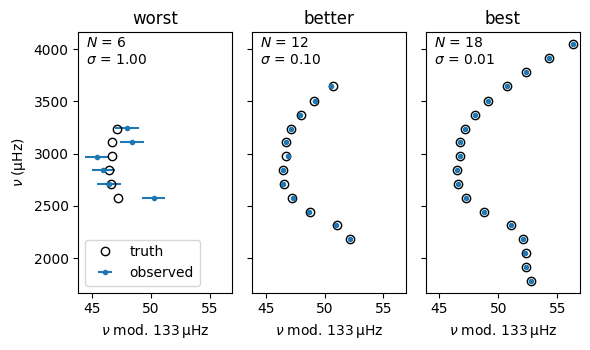

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(6, 3.6), sharey=True, sharex=True, 
                        #  gridspec_kw={"wspace": 0.0}
                        )
delta_nu = 133.0

for i, (k, v) in enumerate(obs.items()):
    ax = axes[i]
    ax.errorbar(v.nu%delta_nu, v.nu, xerr=v.nu_err, fmt=".", label="observed")
    err = v.nu_err.iloc[0]
    ax.text(0.05, 0.88, f"$N$ = {len(v)}\n$\\sigma$ = {err:.2f}", 
            transform=ax.transAxes)
    
    ax.plot(v.nu_true%delta_nu, v.nu_true, "ok", markerfacecolor="none", label="truth")
    ax.set_title(k)
    ax.set_xlabel(f"$\\nu\\;\\mathrm{{mod}}. \\,{delta_nu:.0f}\\,\\mathrm{{\\mu Hz}}$")

axes[0].legend(loc="lower left")
axes[0].set_ylabel(r"$\nu\;(\mathrm{\mu Hz})$")
# fig.supxlabel(f"$\\nu\\,\\% \\,{delta_nu:.0f}\\,\\mathrm{{\\mu Hz}}$")
# fig.supylabel(r"$\nu\;(\mathrm{\mu Hz})$")
fig.tight_layout()
fig.savefig("../figures/glitch-test-obs.pdf", format="pdf", dpi=300)

In [47]:
rng = random.PRNGKey(2023)

In [48]:
shape = (1000,)

gps = {}
for k, v in gp.items():
    rng, key = random.split(rng)
    gps[k] = jd.resample(key, v, shape=shape)

In [49]:
model = {}
for k, v in obs.items():
    n, nu, nu_err = v.n.to_numpy(), v.nu.to_numpy(), v.nu_err.to_numpy()
    delta_nu = jdist.Normal(132.8, 0.1)
    epsilon = jdist.Normal(1.4, 0.05)
    prior = GlitchPrior(delta_nu, epsilon)
    model[k] = GlitchModel(prior, n=n, nu=nu, nu_err=nu_err)

In [50]:
def _oscillation(nu, tau, phi):
    return np.sin(4 * np.pi * tau * nu + phi)

def poly(p, x):
    powers = np.arange(p.shape[-1])
    return np.sum(p*x[..., None]**powers, axis=-1)

def smooth_component(param, n, npoly_params=5):
    return np.apply_along_axis(
        poly, 
        -1,
        param[..., :npoly_params], 
        n,
    )

def helium_amp(param, nu):
    return param[..., -4, None] * nu * np.exp(- 8e-12 * np.pi**2 * param[..., -3, None]**2 * nu**2)

def helium_glitch(param, nu):
    return helium_amp(param, nu) * _oscillation(nu, 1e-6*param[..., -2, None], param[..., -1, None])

def bcz_amp(param, nu):
    return param[..., -7, None] / nu**2

def bcz_glitch(param, nu):
    return bcz_amp(param, nu) * _oscillation(nu, 1e-6*param[..., -6, None], param[..., -5, None])

def glitch(param, nu):
    return helium_glitch(param, nu) + bcz_glitch(param, nu)

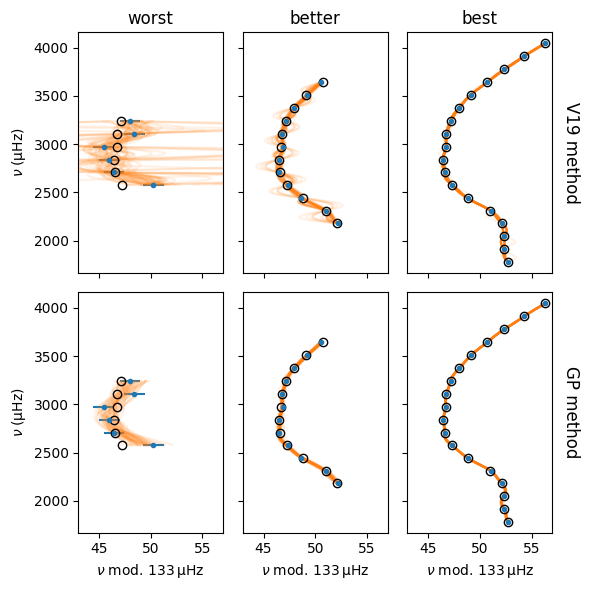

In [11]:
fig, (axtop, axbot) = plt.subplots(2, 3, figsize=(6, 6), sharey=True, sharex=True, 
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
draws = 50
delta_nu = 133.0

for i, (k, v) in enumerate(v19.items()):
    ax = axtop[i]
    ax.set_title(k)
    lobs = ax.errorbar(obs[k].nu%delta_nu, obs[k].nu, xerr=obs[k].nu_err, fmt=".", label="observed")

    thin = len(v) // draws
    n_pred = np.linspace(obs[k].n.min(), obs[k].n.max(), 201)
    param = v.iloc[:, :-2].to_numpy()

    nu_pred = smooth_component(param, n_pred)
    nu_pred += glitch(param, nu_pred)
    x = (nu_pred - n_pred * delta_nu) % delta_nu
    ldraw = ax.plot(x[::thin].T, nu_pred[::thin].T, color="C1", alpha=0.1)
    
    ltrue, = ax.plot(obs[k].nu_true%delta_nu, obs[k].nu_true, "ok",
            markerfacecolor="none", label="truth")
#     if i == 0:
#         ax.legend(loc="upper left")

# ax.legend(handles=[lobs, ltrue, ldraw[0]])
ax.yaxis.set_label_position("right")
ax.set_ylabel("V19 method", rotation=270, labelpad=20., fontsize="large")

for i, (k, v) in enumerate(model.items()):
    ax = axbot[i]
    rng, key = random.split(rng)
    v.plot_echelle(key, gps[k], delta_nu=delta_nu, draws=draws, color="C1", alpha=0.1, ax=ax)
    ax.plot(obs[k].nu_true%delta_nu, obs[k].nu_true, "ok", 
            markerfacecolor="none", label="truth")
    ax.set_xlabel(f"$\\nu\\;\\mathrm{{mod}}. \\,{delta_nu:.0f}\\,\\mathrm{{\\mu Hz}}$")
    
ax.set_xlim(43, 57)
ax.yaxis.set_label_position("right")
ax.set_ylabel("GP method", rotation=270, labelpad=20., fontsize="large")

axtop[0].set_ylabel(r"$\nu\;(\mathrm{\mu Hz})$")
axbot[0].set_ylabel(r"$\nu\;(\mathrm{\mu Hz})$")

# fig.supxlabel(f"$\\nu\\,\\% \\,{delta_nu:.0f}\\,\\mathrm{{\\mu Hz}}$")
# fig.supylabel(r"$\nu\;(\mathrm{\mu Hz})$")
fig.tight_layout()
fig.savefig("../figures/glitch-test-echelle.pdf", format="pdf", dpi=300)

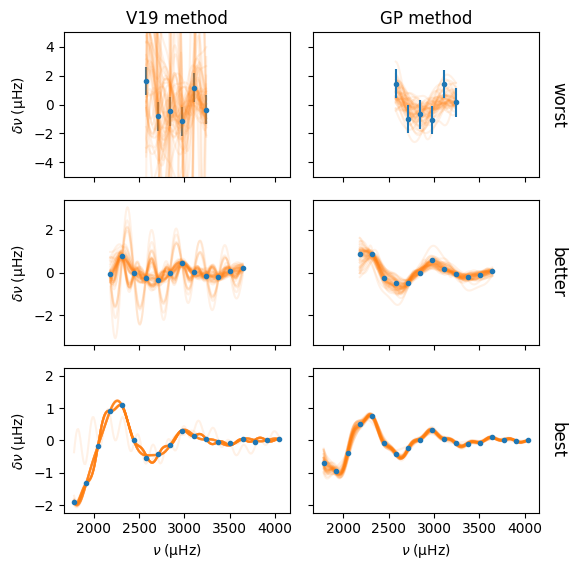

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex=True, 
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T

for i, (k, v) in enumerate(v19.items()):
    ax = axtop[i]

    thin = len(v) // draws
    nu_pred = np.linspace(obs[k].nu.min(), obs[k].nu.max(), 201)
    param = v.iloc[:, :-2].to_numpy()

    nu_sm = np.median(smooth_component(param, obs[k].n.to_numpy()), axis=0)
    dnu = obs[k].nu.to_numpy() - nu_sm
    ax.errorbar(nu_sm, dnu, yerr=obs[k].nu_err, fmt=".", label="observed")
    
    dnu_pred = glitch(param, nu_pred)
    x = np.broadcast_to(nu_pred, dnu_pred.shape)
    ax.plot(x[::thin].T, dnu_pred[::thin].T, color="C1", alpha=0.1)
    ax.set_ylabel(r"$\delta\nu\;(\mathrm{\mu Hz})$")
    
    ylim = min(5, np.abs(ax.get_ylim()).max())
    ax.set_ylim(-ylim, ylim)
    
    if i == 0:
        ax.set_title("V19 method")
#         ax.legend()

for i, (k, v) in enumerate(model.items()):
    ax = axbot[i]
    if i == 0:
        ax.set_title("GP method")
    v.plot_glitch(gps[k], draws=draws, color="C1", alpha=0.1, ax=ax)

    nu_gp, _ = vmap(lambda x: v.predict(x, v.n, include_mean=False))(gps[k])
    nu_sm = vmap(lambda x: v.smooth_component(x, v.n))(gps[k])
    dnu = v.nu - nu_sm - nu_gp
    ax.errorbar(np.median(nu_sm, axis=0), np.median(dnu, axis=0), yerr=v.nu_err, fmt=".")
    
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(k, rotation=270, labelpad=20., fontsize="large")
    
#     ylim = np.abs(ax.get_ylim()).max()
#     ax.set_ylim(-ylim, ylim)

axtop[-1].set_xlabel(r"$\nu\;(\mathrm{\mu Hz})$")
axbot[-1].set_xlabel(r"$\nu\;(\mathrm{\mu Hz})$")

# fig.supxlabel(r"$\nu\;(\mathrm{\mu Hz})$")
# fig.supylabel(r"$\delta\nu\;(\mathrm{\mu Hz})$")

# ax.set_ylim(-3, 3)
fig.tight_layout()
fig.savefig("../figures/glitch-test-signal.pdf", format="pdf", dpi=300)

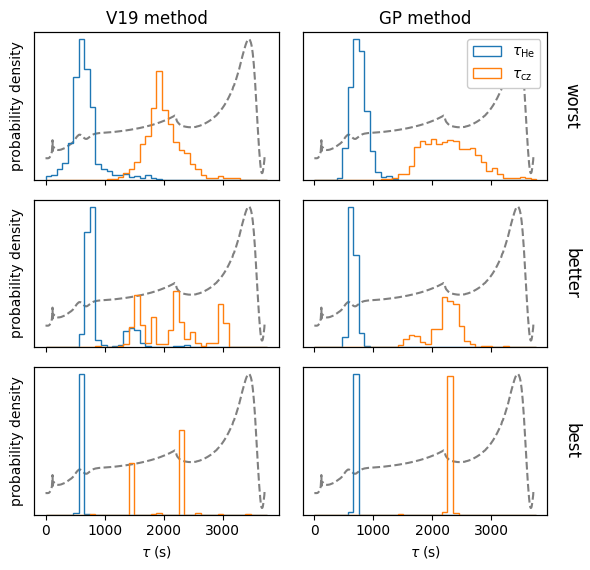

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex="col", 
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T
rlim = (0, 1e6/2/delta_nu)
bins = 40
alpha = 1
histtype = "step"

for i, (k, v) in enumerate(v19.items()):
    ax = axtop[i]
       
    ax.plot(data.tau, 1e-5*differentiate(data.cs, data.tau), "--", c="gray")
#     ax.set_ylabel(r"${\mathrm{d}c}\,/\,{\mathrm{d}\tau}\;(\mathrm{km\,s^{-2}})$")
    ax.set_ylabel(r"probability density")

    ax.set_yticks([])
    
    ax = ax.twinx()
    ax.hist(v["tau_he"], bins=bins, range=rlim, alpha=alpha, histtype=histtype)
    ax.hist(v["tau_cz"], bins=bins, range=rlim, alpha=alpha, histtype=histtype)
    ax.set_yticks([]) 
    
    if i == 0:
        ax.set_title("V19 method")


for i, (k, v) in enumerate(model.items()):
    ax = axbot[i]
    ax.plot(data.tau, 1e-5*differentiate(data.cs, data.tau), "--", c="gray")
    ax.set_yticks([])
    
    ax = ax.twinx()
    
    ax.hist(1e6*np.exp(gps[k]["log_tau_he"]), bins=bins, range=rlim, alpha=alpha, 
            label=r"$\tau_\mathrm{He}$", histtype=histtype)
    ax.hist(1e6*np.exp(gps[k]["log_tau_cz"]), bins=bins, range=rlim, alpha=alpha, 
            label=r"$\tau_\mathrm{cz}$", histtype=histtype)
    
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(k, rotation=270, labelpad=20., fontsize="large")
    ax.set_yticks([])
    
    if i == 0:
        ax.set_title("GP method")
        ax.legend(framealpha=1.0)
    
axtop[-1].set_xlabel(r"$\tau\;(\mathrm{s})$")
axbot[-1].set_xlabel(r"$\tau\;(\mathrm{s})$")

# fig.supxlabel(r"$\nu\;(\mathrm{\mu Hz})$")
# fig.supylabel(r"$\delta\nu\;(\mathrm{\mu Hz})$")

# ax.set_ylim(-3, 3)
fig.tight_layout()
fig.savefig("../figures/glitch-test-tau.pdf", format="pdf", dpi=300)

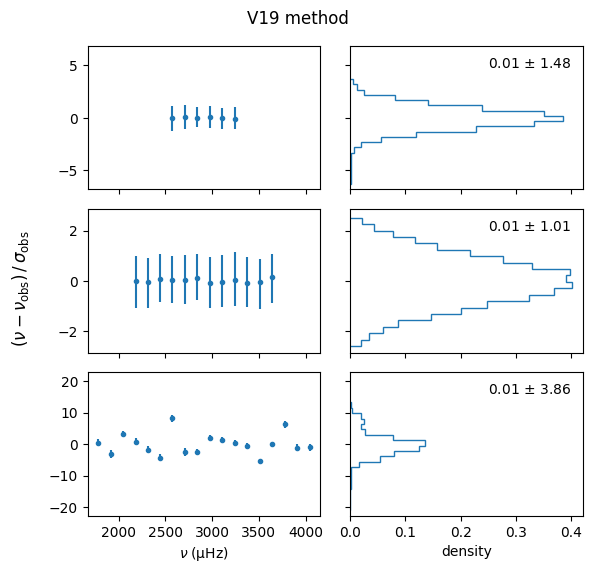

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex="col",
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T

for i, (k, v) in enumerate(v19.items()):
    ax = axtop[i]

    param = v.iloc[:, :-2].to_numpy()
    nu = smooth_component(param, obs[k].n.to_numpy())
    nu += glitch(param, nu)
    
    nu_true = obs[k].nu_true.to_numpy()
    nu_err = obs[k].nu_err.to_numpy()
    nu_obs = obs[k].nu.to_numpy()

    res = (nu - nu_obs) / nu_err
    # res = (nu - nu_true) / nu_err
    res_med = np.median(res, 0)
    res_low, res_upp = np.quantile(res, [.16, .84], 0)
    # plt.plot(nu, res, ".C1", alpha=0.1)
    ax.errorbar(nu_true, res_med, yerr=[res_med-res_low, res_upp-res_med], fmt=".")
    # break
    rmin, rmax = np.quantile(res, [.01, .99], 0)
    ax = axbot[i]
    ax.hist(res.ravel(), bins=20, range=(rmin.min(), rmax.max()), 
            histtype="step", orientation="horizontal", density=True)
    
    ylim = np.abs(ax.get_ylim()).max()
    ax.set_ylim(-ylim, ylim)
    ax.text(0.95, 0.85, f"{res.mean():.2f} $\\pm$ {res.std():.2f}", 
            transform=ax.transAxes, horizontalalignment="right")

axtop[i].set_xlabel(r"$\nu \; (\mathrm{\mu Hz})$")
axbot[i].set_xlabel("density")

fig.suptitle("V19 method")
fig.supylabel(r"$(\nu - \nu_\mathrm{obs}) \, / \, \sigma_\mathrm{obs}$")
fig.tight_layout()

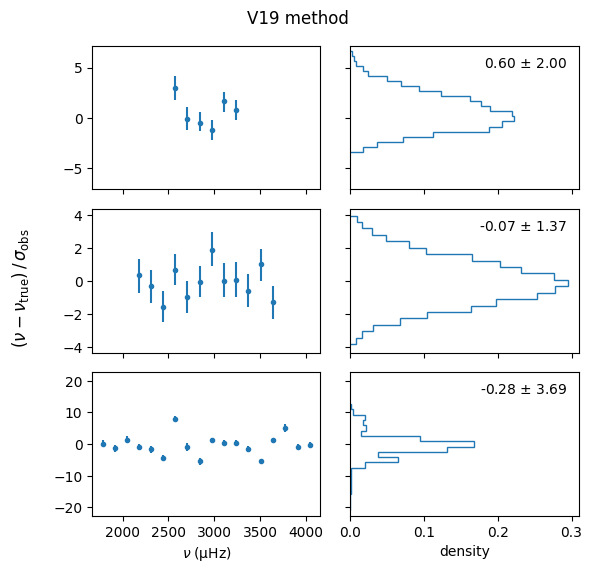

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex="col",
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T

for i, (k, v) in enumerate(v19.items()):
    ax = axtop[i]

    param = v.iloc[:, :-2].to_numpy()
    nu = smooth_component(param, obs[k].n.to_numpy())
    nu += glitch(param, nu)
    
    nu_true = obs[k].nu_true.to_numpy()
    nu_err = obs[k].nu_err.to_numpy()
    nu_obs = obs[k].nu.to_numpy()

    res = (nu - nu_true) / nu_err
    # res = (nu - nu_true) / nu_err
    res_med = np.median(res, 0)
    res_low, res_upp = np.quantile(res, [.16, .84], 0)
    # plt.plot(nu, res, ".C1", alpha=0.1)
    ax.errorbar(nu_true, res_med, yerr=[res_med-res_low, res_upp-res_med], fmt=".")
    # break
    rmin, rmax = np.quantile(res, [.01, .99], 0)
    ax = axbot[i]
    ax.hist(res.ravel(), bins=20, range=(rmin.min(), rmax.max()), 
            histtype="step", orientation="horizontal", density=True)
    
    ylim = np.abs(ax.get_ylim()).max()
    ax.set_ylim(-ylim, ylim)
    ax.text(0.95, 0.85, f"{res.mean():.2f} $\\pm$ {res.std():.2f}", 
            transform=ax.transAxes, horizontalalignment="right")

axtop[i].set_xlabel(r"$\nu \; (\mathrm{\mu Hz})$")
axbot[i].set_xlabel("density")

fig.suptitle("V19 method")
fig.supylabel(r"$(\nu - \nu_\mathrm{true}) \, / \, \sigma_\mathrm{obs}$")
fig.tight_layout()


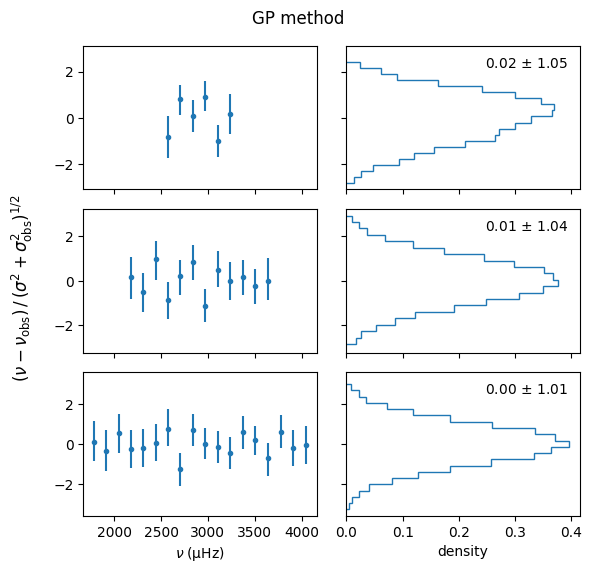

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex="col",
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T

for i, (k, v) in enumerate(model.items()):
    ax = axtop[i]
    
    # nu, nu_var = vmap(lambda x: v.predict(x, v.n))(gps[k])
    keys = random.split(rng, gps[k]["delta_nu"].shape[0])
    nu = vmap(lambda k, x: v.sample(k, x, v.n))(keys, gps[k])
    
    nu_true = obs[k].nu_true.to_numpy()
    nu_err = obs[k].nu_err.to_numpy()
    nu_obs = obs[k].nu.to_numpy()

    sig2 = np.exp(2*gps[k]["log_sigma"])
    res = (nu - nu_obs) / np.sqrt(sig2[:, None] + nu_err**2)
    # res = (nu - nu_obs) / nu_err
    
    # res = (nu - nu_obs) / np.sqrt(nu_var + nu_err**2)
    # res = (nu - nu_true) / np.sqrt(nu_var + nu_err**2)
    res_med = np.median(res, 0)
    res_low, res_upp = np.quantile(res, [.16, .84], 0)
    
    # ax.errorbar(nu_true, nu_obs - nu_true, yerr=nu_err, fmt=".")
    ax.errorbar(nu_true, res_med, yerr=[res_med-res_low, res_upp-res_med], fmt=".")
    
    rmin, rmax = np.quantile(res, [.01, .99], 0)
    ax = axbot[i]
    ax.hist(res.ravel(), bins=20, range=(rmin.min(), rmax.max()),
            histtype="step", orientation="horizontal", density=True)
    
    ylim = np.abs(ax.get_ylim()).max()
    ax.set_ylim(-ylim, ylim)
    ax.text(0.95, 0.85, f"{res.mean():.2f} $\\pm$ {res.std():.2f}", 
            transform=ax.transAxes, horizontalalignment="right")


axtop[i].set_xlabel(r"$\nu \; (\mathrm{\mu Hz})$")
axbot[i].set_xlabel("density")

fig.supylabel(r"$(\nu - \nu_\mathrm{obs}) \, / \, (\sigma^2 + \sigma_\mathrm{obs}^2)^{1/2}$")


fig.suptitle("GP method")
fig.tight_layout()

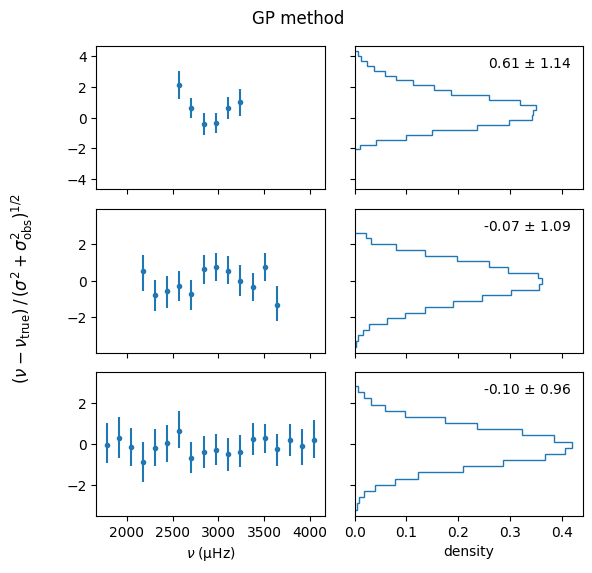

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex="col",
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T

for i, (k, v) in enumerate(model.items()):
    ax = axtop[i]
    
    # nu, nu_var = vmap(lambda x: v.predict(x, v.n))(gps[k])
    keys = random.split(rng, gps[k]["delta_nu"].shape[0])
    nu = vmap(lambda k, x: v.sample(k, x, v.n))(keys, gps[k])
    # Not a great idea to just use nu_var as points are correlated
    nu_true = obs[k].nu_true.to_numpy()
    nu_err = obs[k].nu_err.to_numpy()
    nu_obs = obs[k].nu.to_numpy()

    sig2 = np.exp(2*gps[k]["log_sigma"])
    res = (nu - nu_true) / np.sqrt(sig2[:, None] + nu_err**2)
    # res = (nu - nu_true) / nu_err
    
    # res = (nu - nu_obs) / np.sqrt(nu_var + nu_err**2)
    # res = (nu - nu_true) / np.sqrt(nu_var + nu_err**2)
    res_med = np.median(res, 0)
    res_low, res_upp = np.quantile(res, [.16, .84], 0)
    
    # ax.errorbar(nu_true, nu_obs - nu_true, yerr=nu_err, fmt=".")
    ax.errorbar(nu_true, res_med, yerr=[res_med-res_low, res_upp-res_med], fmt=".")
    
    rmin, rmax = np.quantile(res, [.01, .99], 0)
    ax = axbot[i]
    ax.hist(res.ravel(), bins=20, range=(rmin.min(), rmax.max()),
            histtype="step", orientation="horizontal", density=True)
    
    ylim = np.abs(ax.get_ylim()).max()
    ax.set_ylim(-ylim, ylim)
    ax.text(0.95, 0.85, f"{res.mean():.2f} $\\pm$ {res.std():.2f}", 
            transform=ax.transAxes, horizontalalignment="right")


axtop[i].set_xlabel(r"$\nu \; (\mathrm{\mu Hz})$")
axbot[i].set_xlabel("density")

fig.supylabel(r"$(\nu - \nu_\mathrm{true}) \, / \, (\sigma^2 + \sigma_\mathrm{obs}^2)^{1/2}$")


fig.suptitle("GP method")
fig.tight_layout()

In [18]:
nu_ref = 2900.

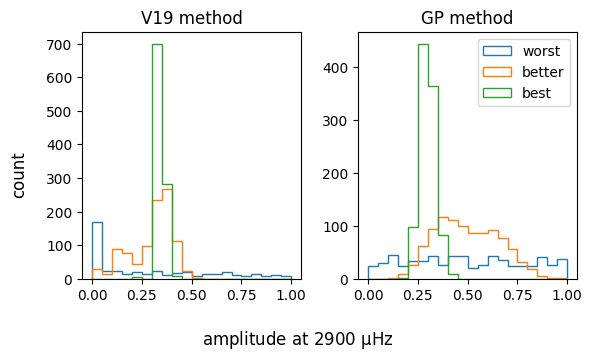

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3.6), sharex=True)

ax = axes[0]
for k, v in v19.items():
    param = v.iloc[:, :-2].to_numpy()
    ahe = helium_amp(param, nu_ref)
    ax.hist(ahe, range=(0, 1), bins=20, histtype="step")
ax.set_title("V19 method")

ax = axes[1]
for k, v in gps.items():
    ahe = model[k].helium_amp(v, nu_ref)
    ax.hist(ahe, range=(0, 1), bins=20, histtype="step", label=k)

ax.legend()
ax.set_title("GP method")

fig.supxlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
fig.supylabel(f"count")

fig.tight_layout()

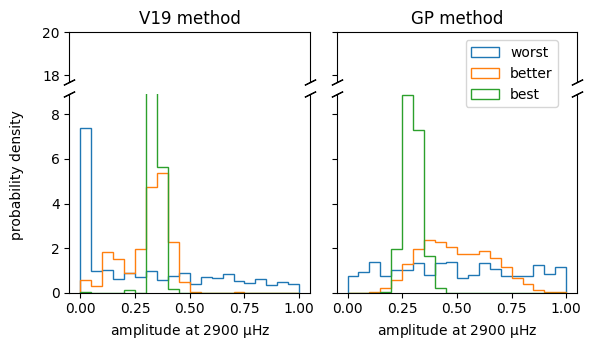

In [20]:
fig, (axtop, axbot) = plt.subplots(2, 2, figsize=(6, 3.6), sharex=True, sharey="row",
                                   gridspec_kw={"height_ratios": [1, 4]})

histtype = "step"
alpha = 1.0
density = True
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
              linestyle="none", color='k', mec='k', mew=0.8, clip_on=False)
    
ax = axbot[0]
axt = axtop[0]
for k, v in v19.items():
    param = v.iloc[:, :-2].to_numpy()
    ahe = helium_amp(param, nu_ref)
#     ax.hist(ahe, range=(0, 1), bins=20, histtype="step")
#     axt.hist(ahe, range=(0, 1), bins=20, histtype="step")
    ax.hist(ahe, range=(0, 1), bins=20, histtype=histtype, alpha=alpha, density=density)
    axt.hist(ahe, range=(0, 1), bins=20, histtype=histtype, alpha=alpha, density=density)
    
    ax.spines['top'].set_visible(False)
    ax.xaxis.tick_bottom()
#     axt.xaxis.tick_top()
    axt.tick_params(labeltop=False, bottom=False)
    axt.spines['bottom'].set_visible(False)
    
    axt.plot([0, 1], [0, 0], transform=axt.transAxes, **kwargs)
    ax.plot([0, 1], [1, 1], transform=ax.transAxes, **kwargs)

ax.set_xlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
# ax.set_ylabel("count")
axt.set_title("V19 method")

ax = axbot[1]
axt = axtop[1]
for k, v in gps.items():
    ahe = model[k].helium_amp(v, nu_ref)
#     ax.hist(ahe, range=(0, 1), bins=20, histtype="step")
    ax.hist(ahe, range=(0, 1), bins=20, histtype=histtype, alpha=alpha,
            density=density, label=k)
#     axt.hist(ahe, range=(0, 1), bins=20, histtype="step", label=k)
    axt.hist(ahe, range=(0, 1), bins=20, histtype=histtype, alpha=alpha, 
             density=density)
    
    ax.spines['top'].set_visible(False)
    ax.xaxis.tick_bottom()
#     axt.tick_params()
    axt.tick_params(labeltop=False, bottom=False)
    axt.spines['bottom'].set_visible(False)
    axt.plot([0, 1], [0, 0], transform=axt.transAxes, **kwargs)
    ax.plot([0, 1], [1, 1], transform=ax.transAxes, **kwargs)
    
ax.set_xlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
ax.legend(loc="lower right", bbox_to_anchor=(0.95, 0.9))


if density:
    ax.set_ylim(0, 8.9)
    axt.set_ylim(17.7, 20)
else:
    ax.set_ylim(0, 350)
    axt.set_ylim(880, 1000)

axt.set_title("GP method")

# fig.supxlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
fig.supylabel(f"probability density", fontsize="medium")
fig.tight_layout()
fig.subplots_adjust(hspace=0.1)
# fig.savefig("../figures/glitch-test-amplitude.eps", format="eps", dpi=300)

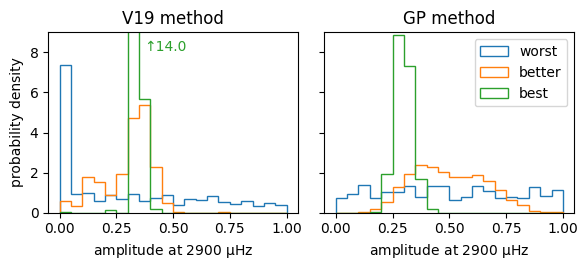

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.8), sharex=True, sharey=True)

histtype = "step"
alpha = 1.0
density = True
ymax = 9
rlim = (0, 1)
ax = axes[0]
for k, v in v19.items():
    param = v.iloc[:, :12].to_numpy()
    ahe = helium_amp(param, nu_ref)
    count, bin_edges, _ = ax.hist(ahe, range=rlim, bins=20, histtype=histtype, alpha=alpha, density=density)
ax.set_title("V19 method")
ax.set_xlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
ax.set_ylabel("probability density")
imax = count.argmax()
xy = (1.06*bin_edges[imax+1], 0.96*ymax)
# xytext = (bin_edges[imax+4], 0.9*ymax)
# ax.annotate(f"{count[imax]:.1f}", xy=xy, xytext=xytext,
#             arrowprops=dict(arrowstyle="->"))
ax.text(*xy, f"↑{count[imax]:.1f}", verticalalignment="top", color="C2")


ax = axes[1]
for k, v in gps.items():
    ahe = model[k].helium_amp(v, nu_ref)
    ax.hist(ahe, range=rlim, bins=20, histtype=histtype, alpha=alpha, density=density, label=k)

ax.legend()
ax.set_title("GP method")
ax.set_ylim(top=ymax)
ax.set_xlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
# fig.supxlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
# fig.supylabel(f"count")

fig.tight_layout()
fig.savefig("../figures/glitch-test-amplitude.pdf", format="pdf", dpi=300)

In [22]:
from corner import corner

In [23]:
k = "better"
df_gp = pd.DataFrame(gps[k])
df_gp.head()

,delta_nu,epsilon,log_alpha_cz,log_alpha_he,log_beta_he,log_sigma,log_tau_cz,log_tau_he,phi_cz,phi_he
0,132.786091,1.414172,8.277245,-11.050914,-15.001763,-2.388193,-6.215490,-7.297451,0.027275,1.195496
1,132.549030,1.463060,7.905772,-10.758429,-14.690085,-1.909558,-6.072033,-7.308497,3.047009,1.289616
2,132.886979,1.412078,8.963021,-11.104482,-15.207348,-5.661675,-6.054631,-7.349618,1.735605,2.436266
3,132.965004,1.436035,8.758946,-10.821829,-15.088949,-2.727378,-6.210919,-7.437417,6.184269,4.267219
4,132.696438,1.376223,7.808250,-11.333729,-15.202003,-6.382465,-6.023643,-7.358914,5.111457,2.860631


In [24]:
log_cols = [col for col in df_gp.columns if col.startswith("log_")]
cols = [col[4:] for col in log_cols]

df_gp[cols] = np.exp(df_gp[log_cols])
sec_cols = ["alpha_he", "tau_he", "tau_cz"]
df_gp[sec_cols] *= 1e6

df_gp.head()

,delta_nu,epsilon,log_alpha_cz,log_alpha_he,log_beta_he,log_sigma,log_tau_cz,log_tau_he,phi_cz,phi_he,alpha_cz,alpha_he,beta_he,sigma,tau_cz,tau_he
0,132.786091,1.414172,8.277245,-11.050914,-15.001763,-2.388193,-6.215490,-7.297451,0.027275,1.195496,3933.342220,15.872632,3.053636e-07,0.091795,1998.236459,677.262784
1,132.549030,1.463060,7.905772,-10.758429,-14.690085,-1.909558,-6.072033,-7.308497,3.047009,1.289616,2712.895614,21.265413,4.170393e-07,0.148146,2306.478552,669.823302
2,132.886979,1.412078,8.963021,-11.104482,-15.207348,-5.661675,-6.054631,-7.349618,1.735605,2.436266,7808.915752,15.044744,2.486180e-07,0.003477,2346.968972,642.838167
3,132.965004,1.436035,8.758946,-10.821829,-15.088949,-2.727378,-6.210919,-7.437417,6.184269,4.267219,6367.396190,19.959037,2.798677e-07,0.065390,2007.391873,588.804166
4,132.696438,1.376223,7.808250,-11.333729,-15.202003,-6.382465,-6.023643,-7.358914,5.111457,2.860631,2460.821310,11.962552,2.499506e-07,0.001691,2420.835566,636.889459


In [25]:
df_gp["delta_he"] = 1e6 * np.sqrt(df_gp["beta_he"]/8) / np.pi
df_gp["a_he"] = 1e-6 * df_gp["alpha_he"] * df_gp["delta_nu"]
df_gp["a_cz"] = df_gp["alpha_cz"] * df_gp["delta_nu"]

In [26]:
v19[k]["log_a_he"] = np.log10(v19[k]["a_he"])
df_gp["log_a_he"] = np.log10(df_gp["a_he"])
v19[k]["log_a_cz"] = np.log10(v19[k]["a_cz"])
df_gp["log_a_cz"] = np.log10(df_gp["a_cz"])

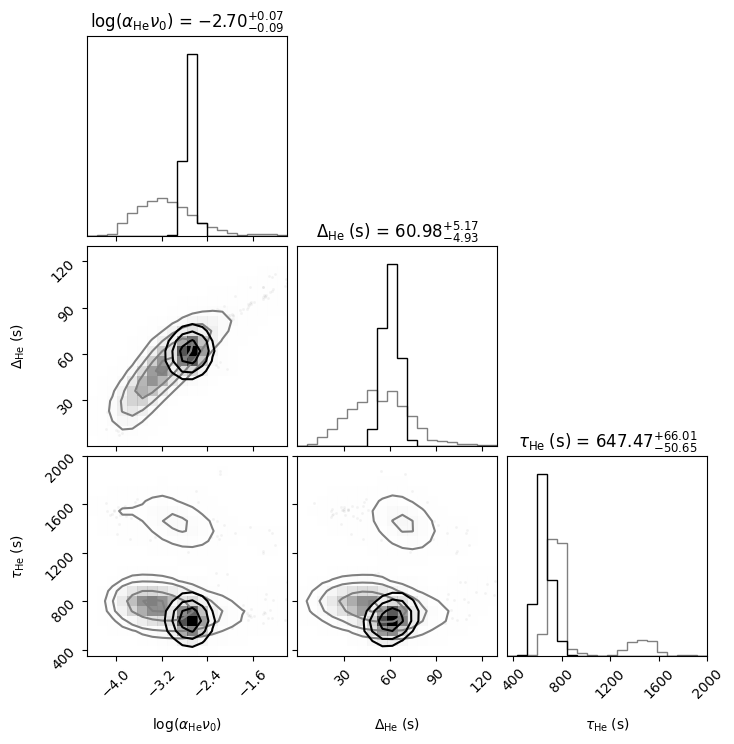

In [27]:
he_cols = ["log_a_he", "delta_he", "tau_he"]
labels = [
    r"$\log(\alpha_\mathrm{He}\nu_0)$", 
    r"$\Delta_\mathrm{He} \; (\mathrm{s})$", 
    r"$\tau_\mathrm{He} \; (\mathrm{s})$"
]
smooth = 1.1
rlim = [(-4.5, -1), (0, 130), (350, 2000)]
fig = corner(v19[k][he_cols], range=rlim, color="gray", smooth=smooth)
fig = corner(df_gp[he_cols], range=rlim, fig=fig, smooth=smooth, 
             labels=labels, show_titles=True)

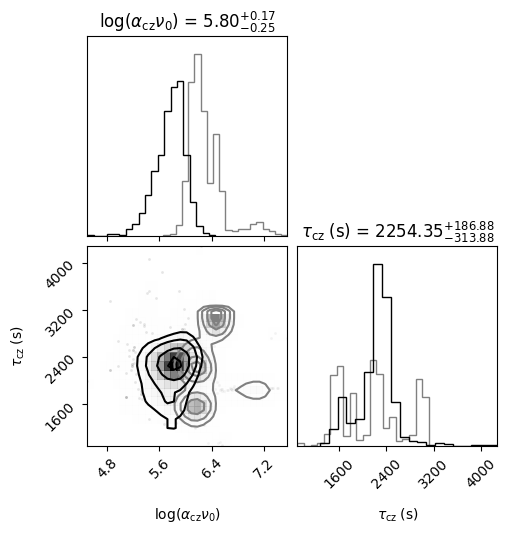

In [28]:
cz_cols = ["log_a_cz", "tau_cz"]
smooth = 1.1
labels = [
    r"$\log(\alpha_\mathrm{cz}\nu_0)$", 
    r"$\tau_\mathrm{cz} \; (\mathrm{s})$"
]

fig = corner(v19[k][cz_cols], color="gray", smooth=smooth)
fig = corner(df_gp[cz_cols], fig=fig, labels=labels, smooth=smooth, show_titles=True)

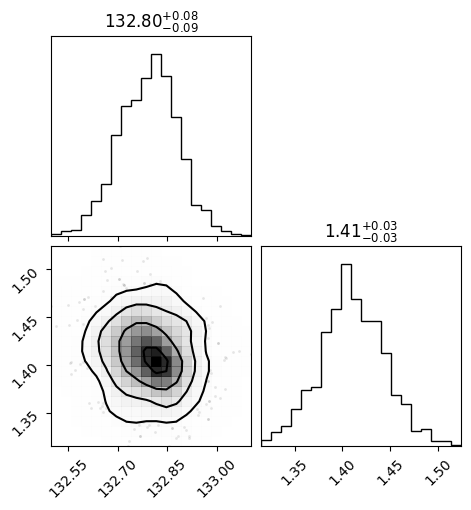

In [29]:
ccols = ["delta_nu", "epsilon"]
fig = corner(df_gp[ccols], smooth=smooth, show_titles=True)

In [59]:
from astroquery.vizier import Vizier

v = Vizier(row_limit=-1)
tables = v.query_constraints("J/ApJ/835/172/table6", KIC="12069424")
obs16a = tables[0].to_pandas()
mask = (obs16a.l == 0) & (obs16a.lnK == 6.0)
obs16a = obs16a.loc[mask]

n, nu, nu_low, nu_high = (obs16a.n.to_numpy(), obs16a.Freq.to_numpy(), 
                          obs16a.e_Freq.to_numpy(), obs16a.E_Freq.to_numpy())
nu_err = np.stack([nu_low, nu_high]).max(axis=0)
obs16a["nu"] = nu
obs16a["nu_err"] = nu_err

# Lund et al. (2017)
delta_nu = jdist.Normal(103.28, 0.05)
epsilon = jdist.Normal(1.45, 0.05)
prior16a = GlitchPrior(delta_nu, epsilon)
model16a = GlitchModel(prior, n=n, nu=nu, nu_err=nu_err)

In [53]:
dfs = {}

m = model["best"]
df = pd.DataFrame()
df[r"Mean"] = m.prior.mean
df[r"Variance"] = m.prior.variance 
df = df.astype(float)
df = df.drop(["phi_he", "phi_cz", "log_sigma"])
df = df.rename(GlitchModel.symbols, axis=0).T
dfs["Test Star"] = df

df = pd.DataFrame()
df[r"Mean"] = prior16a.mean
df[r"Variance"] = prior16a.variance 
df = df.astype(float)
df = df.drop(["phi_he", "phi_cz", "log_sigma"])
df = df.rename(GlitchModel.symbols, axis=0).T
dfs["16 Cyg A"] = df

df = pd.concat(dfs)
df


$\nu_0$  $\varepsilon$  $\ln(\alpha_\mathrm{cz})$  \
Test Star Mean      132.8000         1.4000                   8.290042   
          Variance    0.0100         0.0025                   0.640001   
16 Cyg A  Mean      103.2800         1.4500                   8.038641   
          Variance    0.0025         0.0025                   0.640000   

                    $\ln(\alpha_\mathrm{He})$  $\ln(\beta_\mathrm{He})$  \
Test Star Mean                     -11.100805                -15.065415   
          Variance                   0.040001                  0.160002   
16 Cyg A  Mean                     -10.849404                -14.562614   
          Variance                   0.040000                  0.160001   

                    $\ln(\tau_\mathrm{cz})$  $\ln(\tau_\mathrm{He})$  
Test Star Mean                    -6.092817                -7.191429  
          Variance                 0.040001                 0.040001  
16 Cyg A  Mean                    -5.841417                -6.940029  
          Variance                 0.040000                 0.040000

In [55]:
formatter = dict(zip(df.columns, ["{:.4f}", "{:.4f}", "{:.2f}", "{:.2f}", "{:.2f}", "{:.2f}", "{:.2f}"]))
s = df.style.format(formatter, precision=3)
s.to_latex(
    "../tables/glitch-test-prior.tex",
    hrules=True,
    # column_format="rr|" + len(s.columns)*"r",
)
s

(-1.0, 2.0)

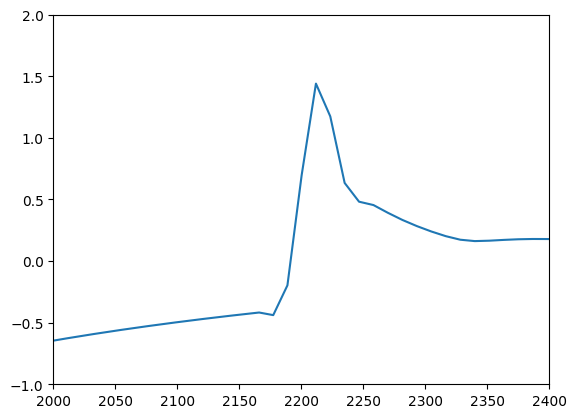

In [32]:
plt.plot(data.tau, 1e20*differentiate(differentiate(np.log(data.rho), data.r), data.r))
plt.xlim(2000, 2400)
# plt.ylim(-1e-12, 1e-12)
plt.ylim(-1, 2)

In [33]:
c_cz = data.cs[data.tau > 2200].values[-1]
c_cz

21345506.788300853

In [34]:
delta_cz = 32 * np.pi**3 / c_cz**2 * df_gp["alpha_cz"] * 1e-12
delta_cz

0      8.565415e-21
1      5.907718e-21
2      1.700503e-20
3      1.386591e-20
4      5.358790e-21
           ...     
995    1.226959e-20
996    1.084215e-20
997    8.842387e-21
998    1.678678e-20
999    1.185198e-20
Name: alpha_cz, Length: 1000, dtype: float64

In [35]:
delta_cz.median()

1.0312779231011041e-20

In [36]:
delta_cz_v = 32 * np.pi**3 / c_cz**2 * v19[k]["a_cz"] * 2 * data.tau.max().values * 1e-18

In [37]:
delta_cz_v.median()

2.7222956186222874e-20

In [38]:
v19["better"]

,b0,b1,b2,b3,b4,a_cz,tau_cz,phi_cz,a_he,delta_he,tau_he,phi_he,chi2,reg,log_a_he,log_a_cz
0,228.809824,133.195840,-0.564329,0.030666,-0.000456,3.090294e+06,3012.175473,2.043389,9.435965e-24,45.611199,817.111782,5.585208,36.856235,1.786981,-23.025214,6.490000
1,273.639708,123.056822,0.275621,0.000382,-0.000054,1.089507e+06,2426.654687,5.884346,1.091587e-03,56.126397,767.282824,4.223381,0.755150,0.356460,-2.961942,6.037230
2,268.707975,123.834670,0.233225,0.001306,-0.000060,9.056088e+05,1541.947176,1.024547,9.535335e-04,54.931463,733.163167,5.550961,0.142159,0.297437,-3.020664,5.956941
3,302.833130,118.340357,0.550728,-0.006381,0.000004,1.432636e+07,1875.085660,2.186444,2.550393e-04,32.757142,757.133346,4.360675,0.258580,0.784840,-3.593393,7.156136
4,272.550457,123.782497,0.184328,0.004571,-0.000119,1.202841e+06,2250.715090,5.029334,1.158225e-03,57.852083,744.793622,4.974572,0.457206,0.626707,-2.936207,6.080208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,266.287512,123.924731,0.258109,-0.000611,-0.000023,3.110253e+06,3103.131285,5.436057,1.363831e-03,70.600547,1432.447199,4.234266,0.431444,0.132936,-2.865239,6.492796
997,281.423489,121.734606,0.359372,-0.001883,-0.000033,7.254489e+05,1580.292831,5.353391,4.077130e-04,43.767484,732.706337,5.476450,0.085361,0.449836,-3.389645,5.860607
998,236.397893,127.591527,0.113939,0.001142,-0.000021,2.794986e+06,2882.366891,0.936169,2.917838e+00,139.379313,872.726490,1.759778,1.183687,0.008523,0.465061,6.446380
999,308.268046,116.837139,0.686865,-0.011459,0.000071,1.387207e+06,2047.848417,5.782058,5.894038e-04,49.257563,739.174031,5.131401,1.414496,0.692270,-3.229587,6.142141


In [39]:
for k, v in v19.items():
    param = v.iloc[:, :12].to_numpy()
    ahe = helium_amp(param, nu_ref)
    ahe_med = np.median(ahe)
    print(ahe_med, *(np.quantile(ahe, [.16, .84])-ahe_med))
    # print(ahe.mean(), ahe.std(ddof=1))

1.1975191456887153 -1.1619695637811875 3.667784093904137
0.33288324360553967 -0.16480786229256209 0.06273242211044239
0.34690139969006467 -0.005234489101477835 0.005739078314339285


In [40]:
for k, v in gps.items():
    ahe = model[k].helium_amp(v, nu_ref)
    ahe_med = np.median(ahe)
    print(ahe_med, *(np.quantile(ahe, [.16, .84])-ahe_med))
    # print(ahe.mean(), ahe.std(ddof=1))

0.7635842536854431 -0.5114756862642065 0.701069128875607
0.4863300189115342 -0.1575067042855791 0.19414548847958218
0.2959032534396083 -0.035916460628868496 0.04197732286597894


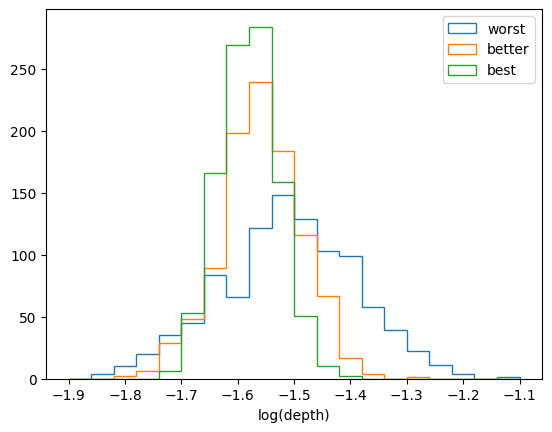

In [41]:
rlim = (-1.9, -1.1)
for k, v in gps.items():
    depth = np.log10(np.e) * (v["log_alpha_he"] - 0.5*v["log_beta_he"])
    plt.hist(depth, range=rlim, bins=20, histtype="step", label=k)
plt.xlabel("log(depth)")
plt.legend();

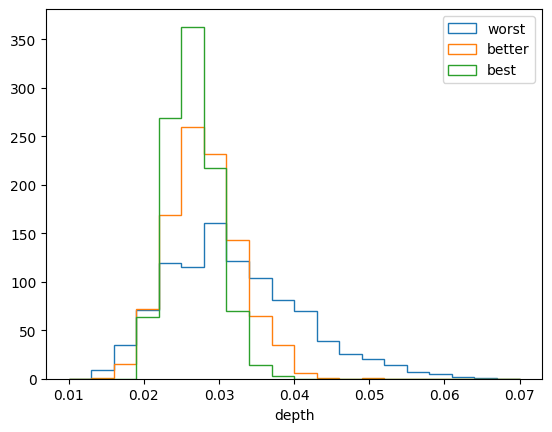

In [42]:
rlim = (1e-2, 7e-2)
for k, v in gps.items():
    depth = np.exp(v["log_alpha_he"] - 0.5*v["log_beta_he"])
    plt.hist(depth, range=rlim, bins=20, histtype="step", label=k)
plt.xlabel("depth")
plt.legend();

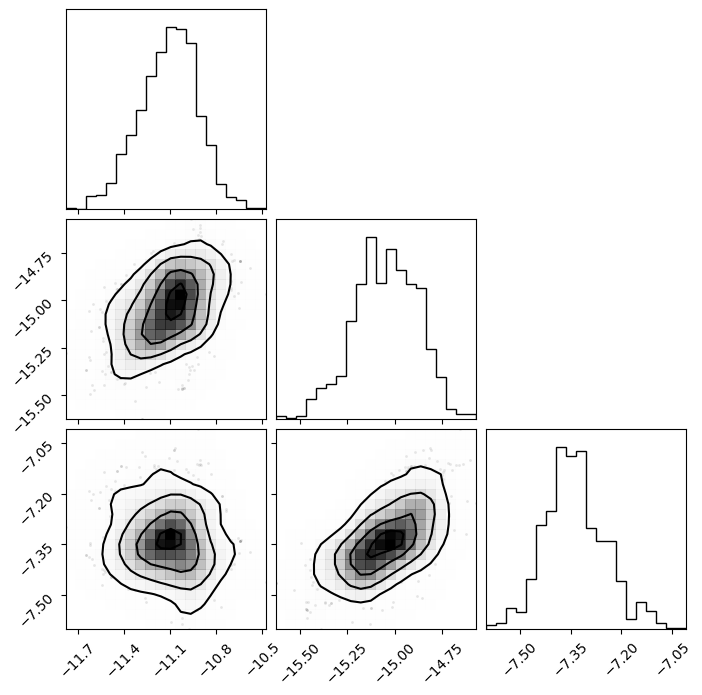

In [43]:
fig = corner(df_gp[["log_alpha_he", "log_beta_he", "log_tau_he"]], smooth=1.1);

In [57]:
v16a = pd.read_csv("data/v19-glitch-results-16cyga.csv", index_col=0)
v16a

,b0,b1,b2,b3,b4,a_cz,tau_cz,phi_cz,a_he,delta_he,tau_he,phi_he,chi2,reg
0,218.470902,92.155771,0.720444,-0.023672,0.000335,3.225652e+06,2445.623579,1.202641,0.008262,107.295160,977.336113,6.167796,9.487531,1.246045
1,161.338540,103.190012,-0.059707,0.000263,0.000066,4.236580e+05,2928.202972,1.215468,0.008558,106.095126,905.007540,1.669212,2.029456,0.873090
2,167.464018,101.660459,0.083359,-0.005671,0.000158,2.743181e+05,2971.123826,0.405216,0.008084,105.419780,931.899544,1.099660,14.856376,1.487741
3,169.353104,101.895584,0.012772,-0.001379,0.000079,2.604893e+05,2961.388406,0.428327,0.006321,100.981822,900.804694,1.781135,8.956390,0.701627
4,193.656327,96.524046,0.454494,-0.017340,0.000292,1.082327e+06,2463.555071,0.728469,0.007621,102.434578,897.282317,1.659063,6.127516,1.651096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,131.140270,109.856932,-0.604653,0.019779,-0.000192,5.024620e+05,2992.180829,5.452816,0.009685,109.061212,919.562728,1.344868,5.639474,1.004054
997,184.751564,98.939981,0.214964,-0.007060,0.000131,3.327010e+05,3020.787591,5.557672,0.011264,112.570860,950.436058,0.548231,6.027302,0.443775
998,162.644977,103.651264,-0.143547,0.004402,0.000003,2.835187e+05,2896.001941,2.077756,0.006010,102.735911,909.166550,1.635722,4.274885,0.601701
999,206.777129,94.106986,0.619248,-0.022331,0.000350,3.108498e+05,1920.611323,5.678899,0.006045,103.851862,928.732638,1.024534,12.299384,1.867612


In [64]:
gp16a = jd.load_results("data/gp-glitch-results-16cyga.h5")
rng, key = random.split(rng)
gps16a = jd.resample(key, gp16a, shape=shape)

In [93]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex="row")

# V19 Glitch
ax = axes[0, 0]
ax.set_title("V19 method")

thin = len(v16a) // draws
nu_pred = np.linspace(obs16a.nu.min(), obs16a.nu.max(), 201)
param = v16a.iloc[:, :-2].to_numpy()

dnu_pred = glitch(param, nu_pred)
x = np.broadcast_to(nu_pred, dnu_pred.shape)
ax.plot(x[::thin].T, dnu_pred[::thin].T, color="C1", alpha=0.1)
ax.set_ylabel(r"$\delta\nu\;(\mathrm{\mu Hz})$")

nu_sm = np.median(smooth_component(param, obs16a.n.to_numpy()), axis=0)
dnu = obs16a.nu.to_numpy() - nu_sm
ax.errorbar(nu_sm, dnu, yerr=obs16a.nu_err, fmt=".", label="observed")

ylim = min(5, np.abs(ax.get_ylim()).max())
ax.set_ylim(-ylim, ylim)
ax.set_xlabel(r"$\nu \; (\mathrm{\mu Hz})$")

# GP Glitch
ax = axes[0, 1]
ax.set_title("GP method")

model16a.plot_glitch(gps16a, draws=draws, color="C1", alpha=0.1, ax=ax)

nu_gp, _ = vmap(lambda x: model16a.predict(x, model16a.n, include_mean=False))(gps16a)
nu_sm = vmap(lambda x: model16a.smooth_component(x, model16a.n))(gps16a)
dnu = model16a.nu - nu_sm - nu_gp
ax.errorbar(np.median(nu_sm, axis=0), np.median(dnu, axis=0), yerr=model16a.nu_err, fmt=".")
ax.set_ylim(-2.8, 2.8)
ax.set_xlabel(r"$\nu \; (\mathrm{\mu Hz})$")


histtype = "step"
bins = 40
rlim = (0, 1e6/2/gps16a["delta_nu"].mean())
alpha = 1.0

# V19 Tau
ax = axes[1, 0]    

ax.set_ylabel(r"probability density")
ax.hist(v16a["tau_he"], bins=bins, range=rlim, alpha=alpha, histtype=histtype)
ax.hist(v16a["tau_cz"], bins=bins, range=rlim, alpha=alpha, histtype=histtype)
ax.set_yticks([]) 
ax.set_xlabel(r"$\tau \; (\mathrm{s})$")

# GP Tau
ax = axes[1, 1]

ax.hist(1e6*np.exp(gps16a["log_tau_he"]), bins=bins, range=rlim, alpha=alpha, 
        label=r"$\tau_\mathrm{He}$", histtype=histtype)
ax.hist(1e6*np.exp(gps16a["log_tau_cz"]), bins=bins, range=rlim, alpha=alpha, 
        label=r"$\tau_\mathrm{cz}$", histtype=histtype)
ax.set_yticks([])
ax.set_xlabel(r"$\tau \; (\mathrm{s})$")
ax.legend()

nu_ref = 2188.5
rlim = (0, 0.75)
# V19 Amp
ax = axes[2, 0]
ax.set_ylabel(r"probability density")
ahe = helium_amp(param, nu_ref)
ax.hist(ahe, range=rlim, bins=bins, histtype=histtype)
acz = bcz_amp(param, nu_ref)
ax.hist(acz, range=rlim, bins=bins, histtype=histtype)
ax.set_yticks([]) 
ax.set_xlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")

# GP Amp
ax = axes[2, 1]
ahe = model16a.helium_amp(gps16a, nu_ref)
ax.hist(ahe, range=rlim, bins=bins, histtype=histtype, label=r"$A_\mathrm{He}$")
acz = model16a.bcz_amp(gps16a, nu_ref)
ax.hist(acz, range=rlim, bins=bins, histtype=histtype, label=r"$A_\mathrm{cz}$")
ax.set_yticks([]) 
ax.set_xlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
ax.legend()

fig.suptitle("16 Cyg A")
fig.savefig("../figures/glitch-16cyga.pdf", format="pdf", dpi=300)
fig.tight_layout()